# Building The Heisman Dataset
***Sean Steinle***


In this notebook, we'll be pulling together the data we need to answer our questions about the Heisman award. Additionally, we'll do some basic data exploration to learn more about which characteristics are related to winning the Heisman.

## Table of Contents

1. [Data Cleaning and Preparation](#1)
    1. [Preparing Votes Data](#1a)
    2. [Setting Up Player and Game APIs](#1b)
    3. [Pulling Stats for Past Heisman Winners](#1c)
2. [Exploratory Data Analysis](#2)
    1. [Extrapositional Factors](#2a)
    2. [Positional Factors](#2b)
3. [Conclusion](#3)

In [1]:
#import libraries
import cfbd
import pandas as pd
import time
import sklearn

<a id='1'></a><a id='1a'></a>

## Preparing Votes Data

I found the results of the past several decades of Heisman voting here: https://www.sports-reference.com/cfb/awards/heisman.html. In order to import it to this notebook, I created a .csv file by hand.

In [2]:
#read in csv of Heisman voting information, use only years past 2003 (cfbd limitation)
votes_df = pd.read_csv("../data/heisman_votes.csv")
votes_df = votes_df[votes_df["Year"] > 2003]
votes_df

,Unnamed: 0,Rk,Player,School,Class,Pos,1st,2nd,3rd,Tot,Summary,Year
0,0,1,DeVonta Smith,Alabama,SR,WR,447,221,73,1856,117 Rec 1856 Yds 15.9 Avg 23 TD,2020
1,1,2,Trevor Lawrence,Clemson,JR,QB,222,176,169,1187,231 Cmp 334 Att 3153 Yds 24 TD 5 Int,2020
2,2,3,Mac Jones,Alabama,JR,QB,138,248,220,1130,311 Cmp 402 Att 4500 Yds 41 TD 4 Int,2020
3,3,4,Kyle Trask,Florida,SR,QB,61,164,226,737,301 Cmp 437 Att 4283 Yds 43 TD 8 Int,2020
4,4,5,Najee Harris,Alabama,SR,RB,16,47,74,216,251 Att 1466 Yds 5.8 Avg 26 TD,2020
...,...,...,...,...,...,...,...,...,...,...,...,...
166,166,6,Cedric Benson,Texas,SR,RB,12,41,69,187,326 Att 1834 Yds 5.6 Avg 19 TD,2004
167,167,7,Jason Campbell,Auburn,SR,QB,21,24,51,162,188 Cmp 270 Att 2700 Yds 20 TD 7 Int,2004
168,168,8,J.J. Arrington,California,SR,RB,10,33,19,115,289 Att 2018 Yds 7.0 Avg 15 TD,2004
169,169,9,Aaron Rodgers,California,JR,QB,8,14,15,67,209 Cmp 316 Att 2566 Yds 24 TD 8 Int,2004


In [3]:
#clean names. names were originally formatted like "Devonta Smith*/devonta-smith24" 
names = []
players = votes_df['Player']
for player in players:
    name = player.split('\\')[0]
    if name[-1] == "*": #weird asterisk thing
        names.append(name[:-1])
    else:
        names.append(name)
votes_df["Player"] = names
votes_df["Player"]

0        DeVonta Smith
1      Trevor Lawrence
2            Mac Jones
3           Kyle Trask
4         Najee Harris
            ...       
166      Cedric Benson
167     Jason Campbell
168     J.J. Arrington
169      Aaron Rodgers
170    Braylon Edwards
Name: Player, Length: 171, dtype: object

In [4]:
#after checking to make sure the names are correct, publish to new csv file.
votes_df.to_csv("heisman_votes.csv")

<a id='1b'></a>

## Setting Up Player and Game APIs

<a id='1bi'></a>

**Configuring Writing Functions**

In this section, I write a trio of functions that will make pulling stats from the API much easier.

In [5]:
#configure API. signup for CFPD api key here: https://collegefootballdata.com/key
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = 'Jr1LRSHRWqFsEIwxZcp0K/NBQRciKdGb9E+GPLFJHHKdFGkShUyyxdhDlZISY2NB'
configuration.api_key_prefix['Authorization'] = 'Bearer'

#CFBD offers a huge number of apis, but we only need the two that tell us about player stats and team records.
players_api = cfbd.PlayersApi(cfbd.ApiClient(configuration))
games_api = cfbd.GamesApi(cfbd.ApiClient(configuration))

In [6]:
#these functions search a given team (ex: 2011 Oregon) for a given player's stats.
#for quarterback, we pull all passing and rushing stats. for runningbacks and wide receivers, we pull all rushing and receiving stats.
#there is the possibility we don't care about every stat the api provides (ex: longest catch), in which can we can manually prune later

def pullStatsQB(name, season, team):
    qb = {}
    qb['NAME'] = name
    players = players_api.get_player_season_stats(year=season,team=team) #'players' is a massive flat list of stats for all players on the team
    for player in players: #more accurately, this would be "for stat in stats"
        if player.player == name:
            if player.category == 'passing': 
                qb["Pass"+player.stat_type] = player.stat
            if player.category == 'rushing':
                qb["Rush"+player.stat_type] = player.stat
    return qb

def pullStatsRB(name, season, team):
    rb = {}
    rb['NAME'] = name
    players = players_api.get_player_season_stats(year=season,team=team)
    for player in players:
        if player.player == name:
            if player.category == 'rushing':
                rb["Rush"+player.stat_type] = player.stat
            if player.category == 'receiving':
                rb["Rec"+player.stat_type] = player.stat
    return rb

def pullStatsWR(name, season, team):
    wr = {}
    wr['NAME'] = name
    players = players_api.get_player_season_stats(year=season,team=team)
    for player in players:
        if player.player == name:
            if player.category == 'rushing':
                wr["Rush"+player.stat_type] = player.stat
            if player.category == 'receiving':
                wr["Rec"+player.stat_type] = player.stat
    return wr

In [7]:
#let's make an additional function to add our heisman stats to these dicts
def addVoteStats(d):
    d['Year'] = row['Year']
    d['School'] = row['School']
    d['Class'] = row['Class']
    d['1stVotes'] = row['1st']
    d['2ndVotes'] = row['2nd']
    d['3rdVotes'] = row['3rd']
    d['TotalVotes'] = row['Tot']
    return d

In [8]:
#let's make one final function that adds the winning percentage of a player's team to the dict
def addTeamStats(d, name, season, team):
    records = games_api.get_team_records(year=season, team=team)
    try:
        d['win_percent'] = records[0].total['wins']/records[0].total['games']
    except:
        d['win_percent'] = -1
    return d

<a id='1bii'></a>

**Testing Functions**

In [15]:
kp = pullStatsQB("Kenny Pickett", 2020, "Pittsburgh")
mi = pullStatsRB("Mark Ingram", 2009, "Alabama")
wr = pullStatsWR("Artavis Scott", 2015, "Clemson")

In [16]:
kp

{'NAME': 'Kenny Pickett',
 'PassYPA': 7.2,
 'PassATT': 333.0,
 'RushYPC': 2.0,
 'RushCAR': 81.0,
 'RushLONG': 18.0,
 'PassCOMPLETIONS': 204.0,
 'RushTD': 8.0,
 'PassPCT': 0.613,
 'PassINT': 9.0,
 'PassYDS': 2408.0,
 'PassTD': 13.0,
 'RushYDS': 162.0}

In [17]:
mi

{'NAME': 'Mark Ingram',
 'RushLONG': 70.0,
 'RecYPR': 10.4,
 'RecTD': 3.0,
 'RecREC': 32.0,
 'RecYDS': 334.0,
 'RecLONG': 69.0,
 'RushCAR': 271.0,
 'RushYPC': 6.1,
 'RushYDS': 1658.0,
 'RushTD': 17.0}

In [18]:
wr

{'NAME': 'Artavis Scott',
 'RushLONG': 10.0,
 'RushYDS': 20.0,
 'RushTD': 1.0,
 'RushCAR': 6.0,
 'RecREC': 93.0,
 'RushYPC': 3.3,
 'RecYDS': 901.0,
 'RecYPR': 9.7,
 'RecTD': 6.0,
 'RecLONG': 51.0}

<a id='1biii'></a>

<a id='link'></a>
**Potential Problems**

There were a few cases where the school names from Sports Reference did not align with the CFBD api, in which case I manually changed them (Brigham Young->BYU, Texas Christian->TCU, etc). Additionally, there are a few other cases of key errors I changed manually after exporting the .csv below. Finally, I dropped fumbles as a statistic because of inconsistent access (some players had simple NaN when other sources said they fumbled).|

<a id='1c'></a>

## Pulling Stats for Past Heisman Winners

In [22]:
#my strategy here is to pull each player's appropriate stats (personal, team, vote) into a dictionary, then append that dictionary to
#a list of dicts for that position. I do this by iterating through each row of the voting dataframe, which contains the players for which
#we have voting data
#NOTE: feel free to run, but it will take aroudn 5-10 minutes.

qbs = []
rbs = []
wrs = []
total_time = time.time()
for i,row in votes_df.iterrows():
    player_time = time.time()
    #gather position specific data
    if row["Pos"] == "QB":
        d = pullStatsQB(row["Player"], row["Year"], row["School"])
        d = addVoteStats(d)
        d = addTeamStats(d, row["Player"], row["Year"], row["School"])
        qbs.append(d)
    elif row["Pos"] == "RB":
        d = pullStatsRB(row["Player"], row["Year"], row["School"])
        d = addVoteStats(d)
        d = addTeamStats(d, row["Player"], row["Year"], row["School"])
        rbs.append(d)
    elif row["Pos"] == "WR":
        d = pullStatsWR(row["Player"], row["Year"], row["School"])
        d = addVoteStats(d)
        d = addTeamStats(d, row["Player"], row["Year"], row["School"])
        wrs.append(d)
    print("Player processed in: ", time.time()-player_time, "seconds")

df_qb = pd.DataFrame(qbs)
df_rb = pd.DataFrame(rbs)
df_wr = pd.DataFrame(wrs)
    
print("Finished processing in ", (time.time()-total_time)/60, "mins")

Player processed in:  2.7538201808929443
Player processed in:  3.755047559738159
Player processed in:  2.10349440574646
Player processed in:  2.5425570011138916
Player processed in:  2.6980347633361816
Player processed in:  2.363010883331299
Player processed in:  2.6869494915008545
Player processed in:  2.774012804031372
Player processed in:  2.586332082748413
Player processed in:  0.0
Player processed in:  2.600045680999756
Player processed in:  4.144778251647949
Player processed in:  4.464840650558472
Player processed in:  0.0
Player processed in:  4.1864402294158936
Player processed in:  4.515452861785889
Player processed in:  4.8936145305633545
Player processed in:  3.9971699714660645
Player processed in:  4.939776182174683
Player processed in:  4.482992887496948
Player processed in:  3.968414783477783
Player processed in:  3.8699867725372314
Player processed in:  4.361812591552734
Player processed in:  4.263803958892822
Player processed in:  4.497437238693237
Player processed in: 

[As I mentioned above](#link), we've done manual edits so we don't want to overwrite these.

In [20]:
#df_qb.to_csv("../data/heisman_QBs_u.csv")
#df_rb.to_csv("../data/heisman_RBs_u.csv")
#df_wr.to_csv("../data/heisman_WRs_u.csv")

<a id='2'></a>
    
## Exploratory Data Analysis

As I mentioned before, I did some manual correction of a few players, so we'll reload the data and begin to summarize from there.

In [9]:
df_qb = pd.read_csv("../data/heisman_QBs.csv")
df_rb = pd.read_csv("../data/heisman_RBs.csv")
df_wr = pd.read_csv("../data/heisman_WRs.csv")

<a id='2a'></a>

### Extrapositional Factors

Let's first investigate important factors that do not vary from position to position. Namely, point voting over time, positional bias, team success, year in school, school repuation, and the relationship between first place vote share and total vote share.

*Positional Bias*

In [10]:
#Positional Vote Share
import matplotlib.pyplot as plt

qbrbwr_total = df_qb['TotalVotes'].sum() + df_rb['TotalVotes'].sum() + df_wr['TotalVotes'].sum()
total = votes_df['Tot'].sum()
print("Total number of points since 2004:", total)
print("QB share of points:", round(df_qb['TotalVotes'].sum()/total*100,2),"%")
print("RB share of points:", round(df_rb['TotalVotes'].sum()/total*100,2),"%")
print("WR share of points:", round(df_wr['TotalVotes'].sum()/total*100, 2),"%")
print("Non-QB/RB/WR share of points:", round((1-(qbrbwr_total/total))*100, 2),"%")

Total number of points since 2004: 88890
QB share of points: 66.62 %
RB share of points: 24.5 %
WR share of points: 4.23 %
Non-QB/RB/WR share of points: 4.65 %


Our analysis is operable on over 95% of points in the past 17 years of Heisman voting. Additionally, our analysis is top heavy--all of the past 17 winners have been a QB (13), RB (3), or WR (1).

Additionally, we see that QBs are almost 3x as likely to win the award than RBs, and RBs are about 5x as likely to win than WRs. This should also show up in our model later.

*Voting Over Time*

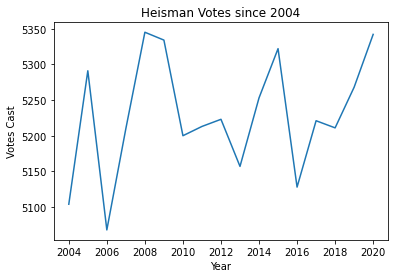

In [25]:
#votes over time/
tot = votes_df.groupby(["Year"]).sum()["Tot"]
plt.plot(tot)
plt.xlabel("Year")
plt.ylabel("Votes Cast")
plt.title("Heisman Votes since 2004")
plt.savefig("../plots/votes_over_time.jpg")

Worth noting here that even the largest jump saw only a 5% vote increase. The number of total points (for the top 10 candidates) has been between 5050 and 5350 since 2004. That said, it makes sense to control for percentage of total point total so lets do that now.

In [12]:
firstVotes = votes_df.groupby(["Year"]).sum()["1st"]
year_fvotes_d = firstVotes.to_dict()
year_votes_d = tot.to_dict()

In [13]:
df_qb["TotalPointShare"] = df_qb["TotalVotes"]/df_qb["Year"].map(year_votes_d)
df_qb["1stVoteShare"] = df_qb["1stVotes"]/df_qb["Year"].map(year_fvotes_d)

df_rb["TotalPointShare"] = df_rb["TotalVotes"]/df_rb["Year"].map(year_votes_d)
df_rb["1stVoteShare"] = df_rb["1stVotes"]/df_rb["Year"].map(year_fvotes_d)

df_wr["TotalPointShare"] = df_wr["TotalVotes"]/df_wr["Year"].map(year_votes_d)
df_wr["1stVoteShare"] = df_wr["1stVotes"]/df_wr["Year"].map(year_fvotes_d)

In [14]:
df_qb.sort_values(by="1stVoteShare", ascending=False)

,NAME,PassPCT,PassYPA,PassCOMPLETIONS,PassINT,RushYPC,RushCAR,PassATT,PassTD,PassYDS,...,Class,1stVotes,2ndVotes,3rdVotes,TotalVotes,win_percent,TotalPointShare,1stVoteShare,ClassNum,SchoolNum
78,Joe Burrow,0.763,10.8,402,6,3.2,115,527,60,5671,...,SR,841,41,3,2608,1.000000,0.495065,0.943883,1,42
10,Troy Smith,0.653,8.2,203,6,2.8,72,311,30,2542,...,SR,801,62,13,2540,0.923077,0.501184,0.910227,1,9
53,Marcus Mariota,0.683,10.0,304,4,5.7,135,445,42,4454,...,JR,788,74,22,2534,0.866667,0.482391,0.885393,0,13
29,Cam Newton,0.661,10.2,185,7,5.6,264,280,30,2854,...,JR,729,24,28,2263,1.000000,0.435192,0.825595,0,3
68,Baker Mayfield,0.705,11.5,285,6,3.2,97,404,43,4627,...,SR,732,87,28,2398,0.857143,0.459299,0.825254,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,Trevone Boykin,0.649,9.0,257,10,5.0,123,396,31,3575,...,SR,1,3,4,13,0.846154,0.002443,0.001117,1,24
55,J.T. Barrett,0.646,9.0,203,10,5.5,171,314,34,2834,...,FR,0,19,40,78,0.933333,0.014849,0.000000,3,9
34,Colin Kaepernick,0.649,8.4,233,8,7.0,173,359,21,3022,...,SR,0,7,17,31,0.928571,0.005962,0.000000,1,23
33,Ryan Mallett,0.647,9.4,266,12,-1.7,44,411,32,3869,...,JR,0,11,19,41,0.769231,0.007885,0.000000,0,22


In [15]:
df_rb.sort_values(by="1stVoteShare", ascending=False)

,Unnamed: 0,NAME,RecLONG,RecYDS,RecTD,RecYPR,RushTD,RushYPC,RushYDS,RecREC,...,Year,School,Class,1stVotes,2ndVotes,3rdVotes,TotalVotes,win_percent,TotalPointShare,1stVoteShare
0,0,Reggie Bush,43,438,2,13.3,16,9.0,1643,33,...,2005,USC,JR,784,89,11,2541,0.923077,0.480249,0.878924
1,1,Derrick Henry,28,91,0,8.3,28,5.6,2219,11,...,2015,Alabama,JR,378,277,144,1832,0.933333,0.344231,0.422346
2,2,Darren McFadden,57,164,1,7.8,16,5.6,1830,21,...,2007,Arkansas,JR,291,355,120,1703,0.615385,0.326871,0.330306
3,3,Christian McCaffrey,75,645,5,14.3,8,6.0,2019,45,...,2015,Stanford,SO,290,246,177,1539,0.857143,0.289177,0.324022
4,4,Mark Ingram,69,334,3,10.4,17,6.1,1658,32,...,2009,Alabama,SO,227,236,151,1304,1.000000,0.244469,0.252784
6,6,Toby Gerhart,33,157,0,14.3,27,5.5,1871,11,...,2009,Stanford,SR,222,225,160,1276,0.615385,0.239220,0.247216
8,8,Adrian Peterson,6,12,0,2.4,15,5.7,1925,5,...,2004,Oklahoma,FR,154,180,175,997,0.923077,0.195337,0.178654
9,9,Trent Richardson,61,338,3,11.7,21,5.9,1679,29,...,2011,Alabama,JR,138,207,150,978,0.923077,0.187608,0.156463
12,12,Reggie Bush,69,509,7,11.8,6,6.3,908,43,...,2004,USC,SO,118,80,83,597,1.000000,0.116967,0.136891
5,5,Bryce Love,12,33,0,5.5,19,8.1,2118,6,...,2017,Stanford,JR,75,421,233,1300,0.642857,0.248994,0.084555


In [16]:
df_wr.sort_values(by="1stVoteShare", ascending=False)

,Unnamed: 0,NAME,RecYPR,RushTD,RecLONG,RecYDS,RushYDS,RushCAR,RecREC,RecTD,...,Year,School,Class,1stVotes,2ndVotes,3rdVotes,TotalVotes,win_percent,TotalPointShare,1stVoteShare
0,0,DeVonta Smith,15.9,1,66,1856,6,4,117,23,...,2020,Alabama,SR,447,221,73,1856,1.000000,0.347435,0.495017
1,1,Amari Cooper,13.9,0,80,1727,23,5,124,16,...,2014,Alabama,JR,49,280,316,1023,0.857143,0.194746,0.055056
3,3,Marqise Lee,14.6,0,83,1721,106,13,118,14,...,2012,USC,SO,19,33,84,207,0.538462,0.039632,0.021300
2,2,Dede Westbrook,19.1,0,88,1524,101,10,80,17,...,2016,Oklahoma,SR,7,49,90,209,0.846154,0.040757,0.007937
7,7,Tavon Austin,11.3,3,75,1289,643,72,114,12,...,2012,West Virginia,SR,6,4,21,47,0.538462,0.008999,0.006726
6,6,Braylon Edwards,13.7,0,69,1330,61,6,97,15,...,2004,Michigan,SR,3,13,27,62,0.750000,0.012147,0.003480
4,4,Michael Crabtree,12.0,0,82,1165,1,2,97,19,...,2008,Texas Tech,SO,3,27,53,116,0.846154,0.021703,0.003326
10,10,Mardy Gilyard,13.7,1,68,1191,16,5,87,11,...,2009,Cincinnati,SR,2,2,13,23,0.923077,0.004312,0.002227
11,11,Golden Tate,16.1,2,78,1496,186,25,93,15,...,2009,Notre Dame,JR,2,3,9,21,0.500000,0.003937,0.002227
8,8,Dwayne Jarrett,14.5,0,62,1015,-3,1,70,12,...,2006,USC,JR,1,11,22,47,0.846154,0.009274,0.001136


In [17]:
#save to csvs (once again we already have our final files)
#df_qb.to_csv("../data/heisman_QBs_u.csv")
#df_rb.to_csv("../data/heisman_RBs_u.csv")
#df_wr.to_csv("../data/heisman_WRs_u.csv")

Now we have a much more standardized way of predicting Heisman winners--proportion of 1st place vote. This is a much better measure than a total point count because it is focused on getting first place votes and it is also scaled to each year's vote total.

*Year in School*

In [18]:
qb_votes_by_class = df_qb.groupby("Class").sum()["TotalVotes"]
qb_fvotes_by_class = df_qb.groupby("Class").sum()["1stVotes"]
print("QBs\n")
print("Total Points:\n",qb_votes_by_class.sort_values(ascending=False)/df_qb["TotalVotes"].sum())
print("\nFirst Place Votes\n",qb_fvotes_by_class.sort_values(ascending=False)/df_qb["1stVotes"].sum())

rb_votes_by_class = df_rb.groupby("Class").sum()["TotalVotes"]
rb_fvotes_by_class = df_rb.groupby("Class").sum()["1stVotes"]
print("\n\nRBs")
print("Total Points:\n",rb_votes_by_class.sort_values(ascending=False)/df_rb["TotalVotes"].sum())
print("\nFirst Place Votes\n",rb_fvotes_by_class.sort_values(ascending=False)/df_rb["1stVotes"].sum())

wr_votes_by_class = df_wr.groupby("Class").sum()["TotalVotes"]
wr_fvotes_by_class = df_wr.groupby("Class").sum()["1stVotes"]
print("\nWRs")
print("Total Points:\n",wr_votes_by_class.sort_values(ascending=False)/df_wr["TotalVotes"].sum())
print("\nFirst Place Votes\n",wr_fvotes_by_class.sort_values(ascending=False)/df_wr["1stVotes"].sum())


QBs

Total Points:
 Class
JR    0.406194
SR    0.307626
SO    0.213364
FR    0.072816
Name: TotalVotes, dtype: float64

First Place Votes
 Class
JR    0.410839
SR    0.307763
SO    0.176858
FR    0.104540
Name: 1stVotes, dtype: float64


RBs
Total Points:
 Class
JR    0.550009
SO    0.271078
SR    0.130465
FR    0.048448
Name: TotalVotes, dtype: float64

First Place Votes
 Class
JR    0.599278
SO    0.240564
SR    0.108960
FR    0.051198
Name: 1stVotes, dtype: float64

WRs
Total Points:
 Class
SR    0.584464
JR    0.301676
SO    0.113860
Name: TotalVotes, dtype: float64

First Place Votes
 Class
SR    0.859519
JR    0.097967
SO    0.042514
Name: 1stVotes, dtype: float64


This checks out logically. Juniors tend to get the most votes for all positions, with sophomores and seniors being secondary and freshman as an afterthought. You can leave for the draft after your sophomore year, so exceptionally talented players have their best college year as a sophomore. Most players take at least one more year, maybe two. One thing to note here is that there is no consideration for redshirting.

*School Factor*

In [19]:
qb_votes_by_school = df_qb.groupby("School").sum()["TotalVotes"]/df_qb["TotalVotes"].sum()
qb_fvotes_by_school = df_qb.groupby("School").sum()["1stVotes"]/df_qb["1stVotes"].sum()
print("QBs\n")
print("Total Points:\n",qb_votes_by_school.sort_values(ascending=False))
print("\nFirst Place Votes\n",qb_fvotes_by_school.sort_values(ascending=False))

rb_votes_by_school = df_rb.groupby("School").sum()["TotalVotes"]/df_rb["TotalVotes"].sum()
rb_fvotes_by_school = df_rb.groupby("School").sum()["1stVotes"]/df_rb["1stVotes"].sum()
print("\n\nRBs")
print("Total Points:\n",rb_votes_by_school.sort_values(ascending=False))
print("\nFirst Place Votes\n",rb_fvotes_by_school.sort_values(ascending=False))

wr_votes_by_school = df_wr.groupby("School").sum()["TotalVotes"]/df_wr["TotalVotes"].sum()
wr_fvotes_by_school = df_wr.groupby("School").sum()["1stVotes"]/df_wr["1stVotes"].sum()
print("\nWRs")
print("Total Points:\n",wr_votes_by_school.sort_values(ascending=False))
print("\nFirst Place Votes\n",wr_fvotes_by_school.sort_values(ascending=False))


QBs

Total Points:
 School
Oklahoma             0.146999
Florida              0.078675
Ohio State           0.074825
Texas                0.073576
Clemson              0.066939
Alabama              0.062971
Louisville           0.049596
Oregon               0.045797
LSU                  0.044041
Stanford             0.041980
Texas A&M            0.041373
Auburn               0.040950
USC                  0.038417
Florida State        0.038097
Baylor               0.030852
Notre Dame           0.017073
Kansas State         0.015097
Hawaii               0.014084
Boise State          0.013932
Utah                 0.010723
Northern Illinois    0.010301
Missouri             0.007177
West Virginia        0.004982
TCU                  0.004407
Texas Tech           0.003597
Washington           0.003073
Navy                 0.003040
Houston              0.002702
Washington State     0.002060
Fresno State         0.001807
UCF                  0.001570
Michigan             0.001418
California   

0.9534053460270964

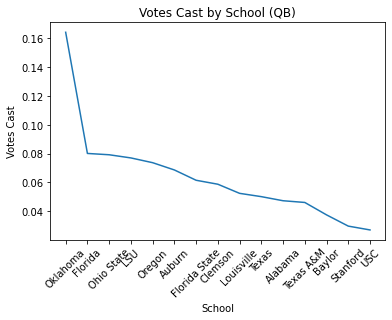

In [40]:
#qb_fvotes_by_school.sort_values(ascending=False)[:15].plot.bar(rot=45)
plt.plot(qb_fvotes_by_school.sort_values(ascending=False)[:15])
plt.xlabel("School")
plt.xticks(rotation=45)
plt.ylabel("Votes Cast")
plt.title("Votes Cast by School (QB)")
plt.savefig("../plots/qb_votes_by_school.jpg")
qb_fvotes_by_school.sort_values(ascending=False)[:15].sum()

In [59]:
print(df_qb['1stVoteShare'].corr(pd.Series(pd.factorize(df_qb['School'])[0])))
print(df_qb['TotalPointShare'].corr(pd.Series(pd.factorize(df_qb['School'])[0])))
print(df_rb['1stVoteShare'].corr(pd.Series(pd.factorize(df_qb['School'])[0])))
print(df_rb['TotalPointShare'].corr(pd.Series(pd.factorize(df_qb['School'])[0])))
print(df_wr['1stVoteShare'].corr(pd.Series(pd.factorize(df_qb['School'])[0])))
print(df_wr['TotalPointShare'].corr(pd.Series(pd.factorize(df_qb['School'])[0])))

-0.05965848051240985
-0.1167898510769948
-0.5064298107634286
-0.6558680300612063
-0.48355062738944155
-0.6173239952473126


0.902855267476206

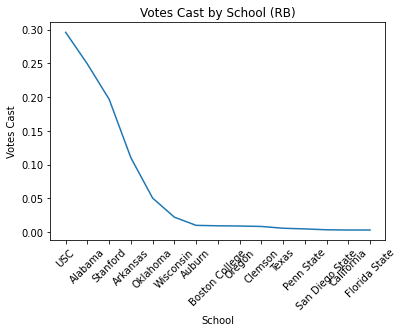

In [39]:
plt.plot(rb_fvotes_by_school.sort_values(ascending=False)[:15])
plt.xlabel("School")
plt.xticks(rotation=45)
plt.ylabel("Votes Cast")
plt.title("Votes Cast by School (RB)")
plt.savefig("../plots/rb_votes_by_school.jpg")
rb_fvotes_by_school.sort_values(ascending=False)[:5].sum()

0.9168207024029574

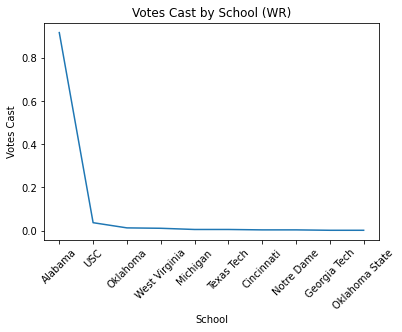

In [38]:
plt.plot(wr_fvotes_by_school.sort_values(ascending=False)[:15])
plt.xlabel("School")
plt.xticks(rotation=45)
plt.ylabel("Votes Cast")
plt.title("Votes Cast by School (WR)")
plt.savefig("../plots/wr_votes_by_school.jpg")
wr_fvotes_by_school.sort_values(ascending=False)[:1].sum()

Interestingly, Heisman votes are very concentrated by school across all three positions. For QBs, only 15 schools represent 95% of the first place votes and 87% of all points in the past 17 years. For RBs, only 5 schools are needed to represent 90% of first place votes. For WRs, Alabama represents well over 80% of first place votes. It makes sense that only a few schools have dominated the RB and WR positions in the Heisman race because there are so few RB and WR candidates.

*Team Success*

In [35]:
print(df_qb["1stVoteShare"].corr(df_qb["win_percent"]))
print(df_rb["1stVoteShare"].corr(df_rb["win_percent"]))
print(df_wr["1stVoteShare"].corr(df_wr["win_percent"])) #This is because Alabama was undefeated during Smith's Heisman campaign.

0.16108030694694714
0.19354693104712548
0.45855776022820083


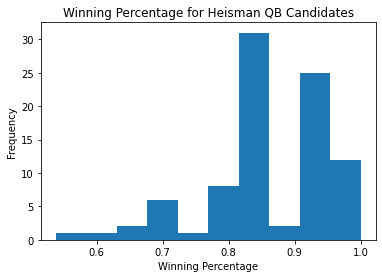

In [41]:
#df_qb["win_percent"].sort_values(ascending=False).plot.bar(rot=45)
plt.hist(df_qb['win_percent'])
plt.xlabel("Winning Percentage")
plt.ylabel("Frequency")
plt.title("Winning Percentage for Heisman QB Candidates")
plt.savefig("../plots/qb_win_hist.jpg")

<AxesSubplot:>

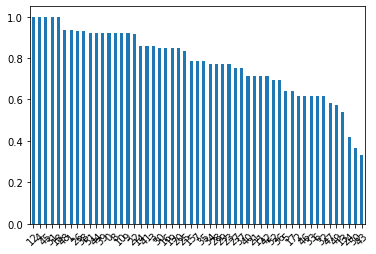

In [20]:
df_rb["win_percent"].sort_values(ascending=False).plot.bar(rot=45)

In [21]:
df_qb.sort_values(by="win_percent",ascending=False).tail(10)

,Unnamed: 0,NAME,PassPCT,PassYPA,PassCOMPLETIONS,PassINT,RushYPC,RushCAR,RushLONG,PassATT,...,Class,1stVotes,2ndVotes,3rdVotes,TotalVotes,win_percent,VoteShare,PointShare,TotalPointShare,1stVoteShare
28,28,Case Keenum,0.703,8.1,492,15,2.6,60,17,700,...,JR,2,9,13,37,0.714286,0.006937,0.006937,0.006937,0.002227
13,13,Tim Tebow,0.669,9.4,234,6,4.3,210,25,350,...,SO,462,229,113,1957,0.692308,0.375624,0.375624,0.375624,0.524404
16,16,Dennis Dixon,0.677,8.4,172,4,5.6,105,80,254,...,SR,17,31,65,178,0.692308,0.034165,0.034165,0.034165,0.019296
49,49,Johnny Manziel,0.699,9.6,300,13,5.3,144,49,429,...,SO,30,103,125,421,0.692308,0.081637,0.081637,0.081637,0.033595
23,23,Pat White,0.657,6.7,180,7,5.1,191,66,274,...,SR,3,1,8,19,0.692308,0.003555,0.003555,0.003555,0.003326
64,64,Lamar Jackson,0.562,8.7,230,9,6.0,260,72,409,...,SO,526,251,64,2144,0.692308,0.418097,0.418097,0.418097,0.596372
85,85,Kyle Trask,0.689,9.8,301,8,0.8,64,26,437,...,SR,61,164,226,737,0.666667,0.137963,0.137963,0.137963,0.067553
75,75,Will Grier,0.670,9.7,266,8,-1.9,49,15,397,...,SR,4,17,80,126,0.666667,0.024180,0.024180,0.024180,0.004556
69,69,Lamar Jackson,0.591,8.5,254,10,6.9,232,75,430,...,JR,47,197,258,793,0.615385,0.151887,0.151887,0.151887,0.052988
32,32,Denard Robinson,0.625,8.8,182,11,6.6,256,87,291,...,SO,6,16,34,84,0.538462,0.016154,0.016154,0.016154,0.006795


In [22]:
df_rb.sort_values(by="win_percent",ascending=False).tail(20)

,Unnamed: 0,NAME,RecLONG,RecYDS,RecTD,RecYPR,RushTD,RushYPC,RushYDS,RecREC,...,Year,School,Class,1stVotes,2ndVotes,3rdVotes,TotalVotes,win_percent,TotalPointShare,1stVoteShare
37,37,Breece Hall,28,180,2,7.8,21,5.6,1573,23,...,2020,Iowa State,SO,6,10,26,64,0.750000,0.011981,0.006645
40,40,Kevin Smith,42,242,1,10.1,29,5.7,2567,24,...,2007,UCF,JR,3,11,24,55,0.714286,0.010557,0.003405
21,21,Jonathan Taylor,36,252,5,9.7,21,6.3,2003,26,...,2019,Wisconsin,JR,6,44,83,189,0.714286,0.035877,0.006734
11,11,Darren McFadden,70,148,1,13.5,14,5.8,1646,11,...,2006,Arkansas,SO,45,298,147,878,0.714286,0.173244,0.051136
42,42,Kerryon Johnson,55,194,2,8.1,18,4.9,1391,24,...,2017,Auburn,JR,0,14,17,45,0.714286,0.008619,0.000000
52,52,Javon Ringer,17,190,0,6.8,22,4.2,1637,28,...,2008,Michigan State,SR,1,0,5,8,0.692308,0.001497,0.001109
36,36,Shonn Greene,23,49,0,6.1,20,6.0,1850,8,...,2008,Iowa,JR,5,9,32,65,0.692308,0.012161,0.005543
5,5,Bryce Love,12,33,0,5.5,19,8.1,2118,6,...,2017,Stanford,JR,75,421,233,1300,0.642857,0.248994,0.084555
17,17,C.J. Spiller,63,503,4,14.0,12,5.6,1212,36,...,2009,Clemson,SR,26,31,83,223,0.642857,0.041807,0.028953
2,2,Darren McFadden,57,164,1,7.8,16,5.6,1830,21,...,2007,Arkansas,JR,291,355,120,1703,0.615385,0.326871,0.330306


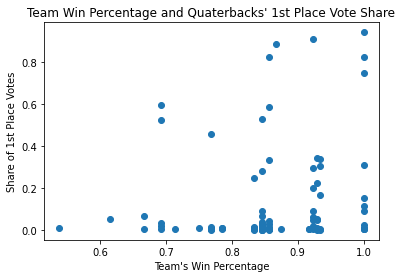

In [62]:
scatter = plt.scatter(df_qb["win_percent"], df_qb["1stVoteShare"])
plt.title("Team Win Percentage and Quaterbacks' 1st Place Vote Share")
plt.xlabel("Team's Win Percentage")
plt.ylabel("Share of 1st Place Votes")
plt.savefig('../plots/qb_winp_vshare.jpg')

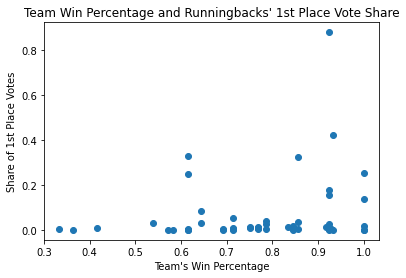

In [60]:
scatter = plt.scatter(df_rb["win_percent"], df_rb["1stVoteShare"])
plt.title("Team Win Percentage and Runningbacks' 1st Place Vote Share")
plt.xlabel("Team's Win Percentage")
plt.ylabel("Share of 1st Place Votes")
plt.savefig('../plots/rb_winp_vshare.jpg')

Although the correlation is low between winning percentage and 1st vote share, it looks like being on a winning team may be acting as a *barrier to winning*.

*1st Place Votes and Total Points*

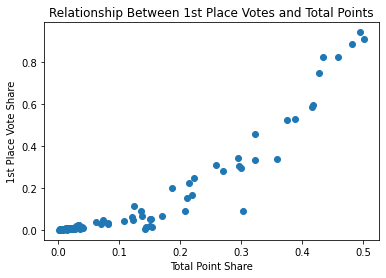

In [61]:
scatter = plt.scatter(df_qb["TotalPointShare"], df_qb["1stVoteShare"])
plt.title("Relationship Between 1st Place Votes and Total Points")
plt.xlabel("Total Point Share")
plt.ylabel("1st Place Vote Share")
plt.savefig('../plots/1st_total_pts.jpg')

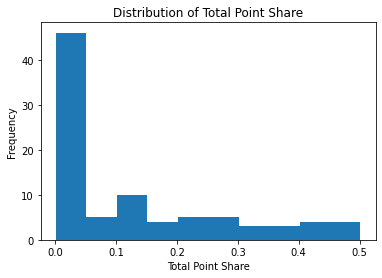

In [67]:
plt.hist(df_qb["TotalPointShare"])
plt.title("Distribution of Total Point Share")
plt.xlabel("Total Point Share")
plt.ylabel("Frequency")
plt.savefig('../plots/total_hist.jpg')

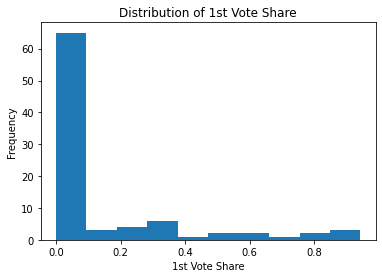

In [68]:
plt.hist(df_qb["1stVoteShare"])
plt.title("Distribution of 1st Vote Share")
plt.xlabel("1st Vote Share")
plt.ylabel("Frequency")
plt.savefig('../plots/1st_hist.jpg')

Interestingly, this scatter plot (as well as the RB/WR versions) takes a concave shape. This is likely because there tends to be a concentration of players who do not get many first place votes but still get a lot of total points from 2nd and 3rd place votes. This concentration may be increased by unified Heisman races, where there are clear winners and runner-ups.

<a id='2b'></a>
### Positional Factors

<a id='2b'></a>

**QB Factors**

In [58]:
for col in df_qb.columns[1:]:
    try:
        print(col,"- Total:",df_qb["TotalPointShare"].corr(df_qb[col]))
        print(col,"- 1st:",df_qb["1stVoteShare"].corr(df_qb[col]))
        print()
    except:
        print(col)


NAME
PassPCT - Total: 0.23659547264686845
PassPCT - 1st: 0.19262524428884653

PassYPA - Total: 0.3164623654485456
PassYPA - 1st: 0.3263232813455632

PassCOMPLETIONS - Total: 0.06858624701971816
PassCOMPLETIONS - 1st: 0.046039541831331514

PassINT - Total: -0.04976746421076936
PassINT - 1st: -0.09460102420080001

RushYPC - Total: 0.16240880542300604
RushYPC - 1st: 0.15102312214030728

RushCAR - Total: 0.1680870001310543
RushCAR - 1st: 0.15520344984430137

RushLONG - Total: 0.12825352477303392
RushLONG - 1st: 0.11780409584884327

PassATT - Total: 0.014819829130859335
PassATT - 1st: -0.001512031865569526

PassTD - Total: 0.2805205140519355
PassTD - 1st: 0.27029081959234785

PassYDS - Total: 0.18569258322625465
PassYDS - 1st: 0.17564681666168447

RushTD - Total: 0.1737329595799434
RushTD - 1st: 0.14829662676410166

RushYDS - Total: 0.14974743521823214
RushYDS - 1st: 0.1342346264076506

Year - Total: 0.021610344886990967
Year - 1st: 0.041551830233845705

School
Class
1stVotes - Total: 0.927

<a id='2c'></a>

**RB Factors**

In [59]:
for col in df_rb.columns[1:]:
    try:
        print(col,"- Total:",df_rb["TotalPointShare"].corr(df_rb[col]))
        print(col,"- 1st:",df_rb["1stVoteShare"].corr(df_rb[col]))
        print()
    except:
        print(col)


NAME
RecLONG - Total: 0.147991085293058
RecLONG - 1st: 0.1731707898907815

RecYDS - Total: 0.14431448811327383
RecYDS - 1st: 0.23142083801233476

RecTD - Total: 0.1385258352951477
RecTD - 1st: 0.10026553450380549

RecYPR - Total: 0.1255524251800484
RecYPR - 1st: 0.17071944349274593

RushTD - Total: 0.006635580681575422
RushTD - 1st: -0.07641845770394334

RushYPC - Total: 0.13080076509411662
RushYPC - 1st: 0.17108475046534372

RushYDS - Total: 0.13823540812549173
RushYDS - 1st: 0.02110660463996879

RecREC - Total: 0.04379775861268012
RecREC - 1st: 0.1436623077275603

RushLONG - Total: 0.02004764834942501
RushLONG - 1st: 0.06592133595217785

RushCAR - Total: 0.09219682638673476
RushCAR - 1st: -0.026228235560170433

Year - Total: -0.23140980399575595
Year - 1st: -0.24823229835594635

School
Class
1stVotes - Total: 0.8833366738326157
1stVotes - 1st: 0.9999640436484569

2ndVotes - Total: 0.801455910333493
2ndVotes - 1st: 0.4318202989845302

3rdVotes - Total: 0.6554661248654257
3rdVotes - 1s

<a id='2d'></a>

**WR Factors**

In [60]:
for col in df_wr.columns[1:]:
    try:
        print(col,"- Total:",df_wr["TotalPointShare"].corr(df_wr[col]))
        print(col,"- 1st:",df_wr["1stVoteShare"].corr(df_wr[col]))
        print()
    except:
        print(col)


NAME
RecYPR - Total: 0.1478668962744687
RecYPR - 1st: 0.16637794304511921

RushTD - Total: -0.059513259182192836
RushTD - 1st: 0.08024985239559747

RecLONG - Total: -0.12481603415872498
RecLONG - 1st: -0.29572405873224533

RecYDS - Total: 0.6325065801965495
RecYDS - 1st: 0.5141049481215412

RushYDS - Total: -0.24224415486963355
RushYDS - 1st: -0.18050085246808967

RushCAR - Total: -0.2116608255993316
RushCAR - 1st: -0.1473938336136305

RecREC - Total: 0.5325592235714206
RecREC - 1st: 0.3831164496161112

RecTD - Total: 0.6353129208540333
RecTD - 1st: 0.6449760390590482

RushYPC - Total: -0.2466261101639444
RushYPC - 1st: -0.2635453241317653

RushLONG - Total: -0.19611406124084138
RushLONG - 1st: -0.18472683528093775

Year - Total: 0.7649678811949986
Year - 1st: 0.6941391375540936

School
Class
1stVotes - Total: 0.9125135601496942
1stVotes - 1st: 0.9999987415798346

2ndVotes - Total: 0.8985782888719355
2ndVotes - 1st: 0.6427394495907841

3rdVotes - Total: 0.5228406449154575
3rdVotes - 1s

Few of these statistics seem to be strongly or even moderately correlated with either total points or first place votes, though there are a number of statistics that are weakly correlated. For QBs, YPA, PassTD, and Completion % are all r > 0.20. Concerningly for RBs, many receiving statistics are actually more correlated than their rushing counterparts. WRs have much more logical correlations, with a few statistics being moderately correlated with total points and first votes.

<a id='3'></a>
## Conclusion

In this notebook, we consolidated our data into three dataframes that include all of the factors we're interesting in considering for QBs, RBs, and WRs. We also did some exploratory data analysis, finding that there are not very many highly correlated statistics with Heisman vote share. This is an ominous sign for our future modeling, but our next step is to decide which features are worth keeping and create one dataframe to contain all of our candidates. Additionally, we'll need to convert some categorical variables like position, year in school, and name of school.